Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


In [6]:
import pandas as pd 


drive.mount(ROOT)
%cd '{REPO_PATH}'

In [9]:
repo_name = 'politicalbias'
GIT_REPO = 'https://github.com/thekhan314/politicalbias.git'


from os.path import join

BASE = 'My Drive/Colab Notebooks/'
ROOT = '/content/drive/'
PROJECT_PATH = join(ROOT,BASE)
REPO_PATH = join(PROJECT_PATH,repo_name)

drive.mount(ROOT)
%cd '{REPO_PATH}'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/politicalbias


# IBC Data

Pulled from 
Columns:


In [10]:
df_ibc = pd.read_csv('data/IBC_data_2_labels.csv')

In [15]:
df_ibc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4326 entries, 0 to 4325
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  4326 non-null   object
 1   Label     4326 non-null   object
dtypes: object(2)
memory usage: 67.7+ KB


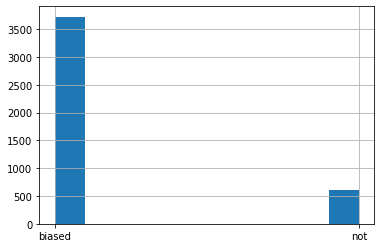

In [16]:
df_ibc['Label'].hist()

In [ ]:
# Fit a baseline model, pull weights, cluster somehow and find most common hate words

# adfontes

In [18]:
df_adf = pd.read_csv('data/adfontes_political_bias.csv')
df_adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   article_title  3707 non-null   object 
 1   article_bias   3707 non-null   float64
 2   reliability    3707 non-null   float64
 3   article_url    3707 non-null   object 
 4   article_text   3707 non-null   object 
 5   length         3707 non-null   int64  
 6   bias           3707 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 202.9+ KB


In [19]:
df_adf.describe()

,article_bias,reliability,length
count,3707.000000,3707.000000,3707.000000
mean,-1.485624,39.377302,5402.093337
std,13.070018,10.182412,5361.245523
min,-38.250000,1.000000,505.000000
25%,-8.670000,33.550000,2562.500000
50%,-1.330000,42.110000,4077.000000
75%,1.585000,46.865000,6496.500000
max,42.000000,61.110000,100000.000000


In [20]:
df_adf.head()

,article_title,article_bias,reliability,article_url,article_text,length,bias
0,Quotes from US Democrats falsely characterized...,-11.33,28.09,https://factcheck.afp.com/quotes-us-democrats-...,Quotes from US Democrats falsely characterized...,7282,left
1,Human error in Michigan county vote tally spar...,0.00,47.52,https://factcheck.afp.com/human-error-michigan...,Human error in Michigan county vote tally spar...,3524,centre
2,Tweets on US stimulus misrepresent Canada's Co...,0.00,46.85,https://factcheck.afp.com/tweets-us-stimulus-m...,Tweets on US stimulus misrepresent Canada's Co...,4796,centre
3,This video shares a misleading claim from an A...,0.00,45.85,https://factcheck.afp.com/video-shares-mislead...,This video shares a misleading claim from an A...,3384,centre
4,Four seasons in Wuhan,0.00,39.85,https://correspondent.afp.com/four-seasons-wuhan,"Four seasons in Wuhan\n\n""​I headed to the tra...",8687,centre


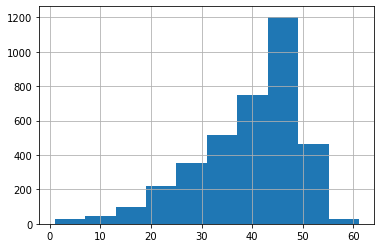

In [21]:
df_adf['reliability'].hist()

# Political Bias

In [23]:
df_ant = pd.read_csv('data/political_bias_summarized_binary_levels.csv')


In [24]:
df_ant.head()

,article_text,word_count,summary,summary_word_count,label
0,maggie clark pewstateline staff writer 21 stat...,704,maggie clark pewstateline staff writer 21 stat...,1298,Neutral
1,washington the senate judiciary committee app...,1142,washington the senate judiciary committee app...,912,Neutral
2,david cole is a professor of constitutional la...,1408,david cole is a professor of constitutional la...,1210,Neutral
3,parts of obamacare are starting to fray even b...,809,parts of obamacare are starting to fray even b...,907,Neutral
4,u.s. immigration citizenship and immigration s...,962,immigration citizenship and immigration servic...,870,Neutral


In [26]:
df_ant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9458 entries, 0 to 9457
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   article_text        9458 non-null   object
 1   word_count          9458 non-null   int64 
 2   summary             9447 non-null   object
 3   summary_word_count  9458 non-null   int64 
 4   label               9458 non-null   object
dtypes: int64(2), object(3)
memory usage: 369.6+ KB
